![Avatar foto de Flávio Coutinho](https://fegemo.github.io/cefet-front-end/images/flavio-avatar.jpg)
# TP1 - Detecção de Exoplanetas


<dl style="margin-top: 1.5em">
    <dt>Aluno</dt><dd>Flávio Coutinho</dd>
    <dt>Turma</dt><dd>Aprendizado de Máquina, UFMG, 01/21</dd>
    <dt>Objetivo</dt><dd>Utilizar e comparar diferentes métodos de classificação para detectar exoplanetas a partir de dados do Kepler.</dd>
    <dt>Link</dt><dd><a href="https://fegemo.github.io/ml-exoplanets/" target="_blank">https://fegemo.github.io/ml-exoplanets/</a>
</dl>

Conteúdo deste _notebook_:
- [Descrição dos dados](#Descrição-dos-dados)
- [Preparação dos dados](#Preparação-dos-dados)
- [Métodos de classificação](#Métodos-de-classificação)
   - [Naive Bayes](#Naive-Bayes)
   - [Decision Tree](#Decision-Tree)
   - [SVM](#SVM)
   - [k-NN](#k-NN)
   - [Random Forest](#Random-Forest)
   - [Gradient Tree Boosting](#Gradient-Tree-Boosting)
- [Comparação dos métodos](#Comparação-dos-métodos)


In [1]:
"""
Inicialização e importação
"""
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':300})

import numpy as np
import pandas as pd

In [2]:
"""
Define uma folha de estilos pro notebook
"""
from IPython.core.display import HTML
def css_styling():
    styles = "<style>" + open("./estilos.css", "r").read() + "</style>"
    return HTML(styles)
css_styling()

## Descrição dos dados

O arquivo `koi_data.csv` possui 1.490KB e contém 43 colunas e 5202 linhas de dados (+1 de cabeçalho). Uma amostra dos dados:

In [3]:
df_original = pd.read_csv("koi_data.csv", header=0)
df_original.head()

,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,CONFIRMED,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,K00754.01,FALSE POSITIVE,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,K00755.01,CONFIRMED,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,K00114.01,FALSE POSITIVE,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,...,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


In [4]:
print("Dimensões: ", df_original.shape)

Dimensões:  (5202, 43)


In [5]:
confirmed_ratio = len(df_original.loc[df_original["koi_disposition"] == "CONFIRMED"]) / df_original.shape[0]
not_confirmed_ratio = 1 - confirmed_ratio
print(f"Taxa de confirmados: {confirmed_ratio:.2f}")
print(f"Taxa de não-confirmados: {not_confirmed_ratio:.2f}")

Taxa de confirmados: 0.40
Taxa de não-confirmados: 0.60


## Preparação dos dados

Os dados carregados são primeiramente preparados e normalizados para, então, serem submetidos aos estimadores. Preparação:

1. Remover colunas desnecessárias para classificadores (`kepoi_name`)
1. Atribuir valor numérico para coluna de rótulos $y$ (`koi_disposition`)
1. Embaralha as linhas
1. Converte o `DataFrame` para `np.ndarray`
1. Divide o `ndarray` nos vetores `X` (todas as _features_) e `y` (apenas rótulos)
1. Particiona em dados de treino e teste
1. Padroniza as _features_ para terem média $0$ e variância $1$


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# 1. remove coluna
df = df_original.drop(labels="kepoi_name", axis=1)

# 2. valor numérico para rótulo
df["koi_disposition"] = df["koi_disposition"].map({
    "CONFIRMED": 1,
    "FALSE POSITIVE": 0
})

# 3. embaralha
df = df.sample(frac=1)

# 4. DataFrame >> ndarray
# 5. X, y
dados = df.to_numpy()
y = dados[:, 0]
X = dados[:, 1:]

# 6. particiona em dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

# 7. padroniza todas as features de treino (X_train) depois faz o mesmo para X_test
padronizador = StandardScaler().fit(X_train)
X_train = padronizador.transform(X_train)
X_test = padronizador.transform(X_test)

## Métodos de classificação

Primeiramente, algumas funções utilitárias para fazer uma (a) busca de hiperparâmetros de classificadores, outra para (b) mostrar um gráfico com os candidatos a melhor estimador e outra para (c) apresentar detalhes do melhor estimador.

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV


"""
Faz uma busca em um ou mais hiperparâmetros pelo melhor estimador.
"""
def search_for_best_estimator(estimator, params, X, y):
    searcher = GridSearchCV(estimator, params, scoring="accuracy", verbose=3, n_jobs=-1)
    searcher.fit(X, y)
    return searcher, searcher.cv_results_["mean_test_score"]


"""
Mostra um gráfico de barras com o resultado de acurácia para vários estimadores.
"""
def plot_estimator_scores(scores, param_values, param_name, title):
    # configura tamanhos da imagem
    plt.rc("axes", titlesize=4)     # fontsize of the axes title
    plt.rc("xtick", labelsize=3)    # fontsize of the tick labels
    plt.rc("ytick", labelsize=3)    # fontsize of the tick labels
    plt.rc("font", size=3)          # controls default text sizes

    fig, ax = plt.subplots(figsize=(2, 1))
    fig.suptitle(title, fontsize=4)
    ax.grid(axis="y", linewidth=0.1)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.1)
    ax.tick_params(width=0.1)

    # eixo y
    # menor valor de scores - um epsilon (limitado inferiormente a 0)
    y_low_lim = max(0, 0.9 * min(scores))
    ax.set_ylim([y_low_lim, 1])
    ax.set_ylabel("Acurácia")

    # eixo x
    x = range(len(param_values))
    ax.set_xlabel(param_name)
    ax.set_xticks([])

    best_score = max(scores)
    colors = ["#b1db09" if s == best_score else "#14aaf2" for s in scores]
    ax.bar(x, scores, tick_label=[v or 'None' for v in param_values], color=colors, linewidth=0.001)


"""
Mostra detalhes do resultado de um estimador
"""
def show_estimator_results(estimator, params, estimator_name):
    print(f"Resultados para {estimator_name}:")
    print(f"  - Acurária: {estimator.best_score_}")
    print(f"  - Parâmetro(s): {', '.join('{}: {}'.format(k, v) for k, v in estimator.best_params_.items())}")

    
    



### Naive Bayes

Usado como _baseline_, o _Naive Bayes_ aplica o teorema de _Bayes_ porém assumindo a independência entre as _features_ do dado (para se tornar computacionalmente tratável). Implementações diferentes consideram diferentes distribuições de probabilidade $P(x_i|Y)$. Portanto, neste experimento vamos verificar visualmente a distribuição dos 42 atributos dos exoplanetas para, então, decidir pela implementação:

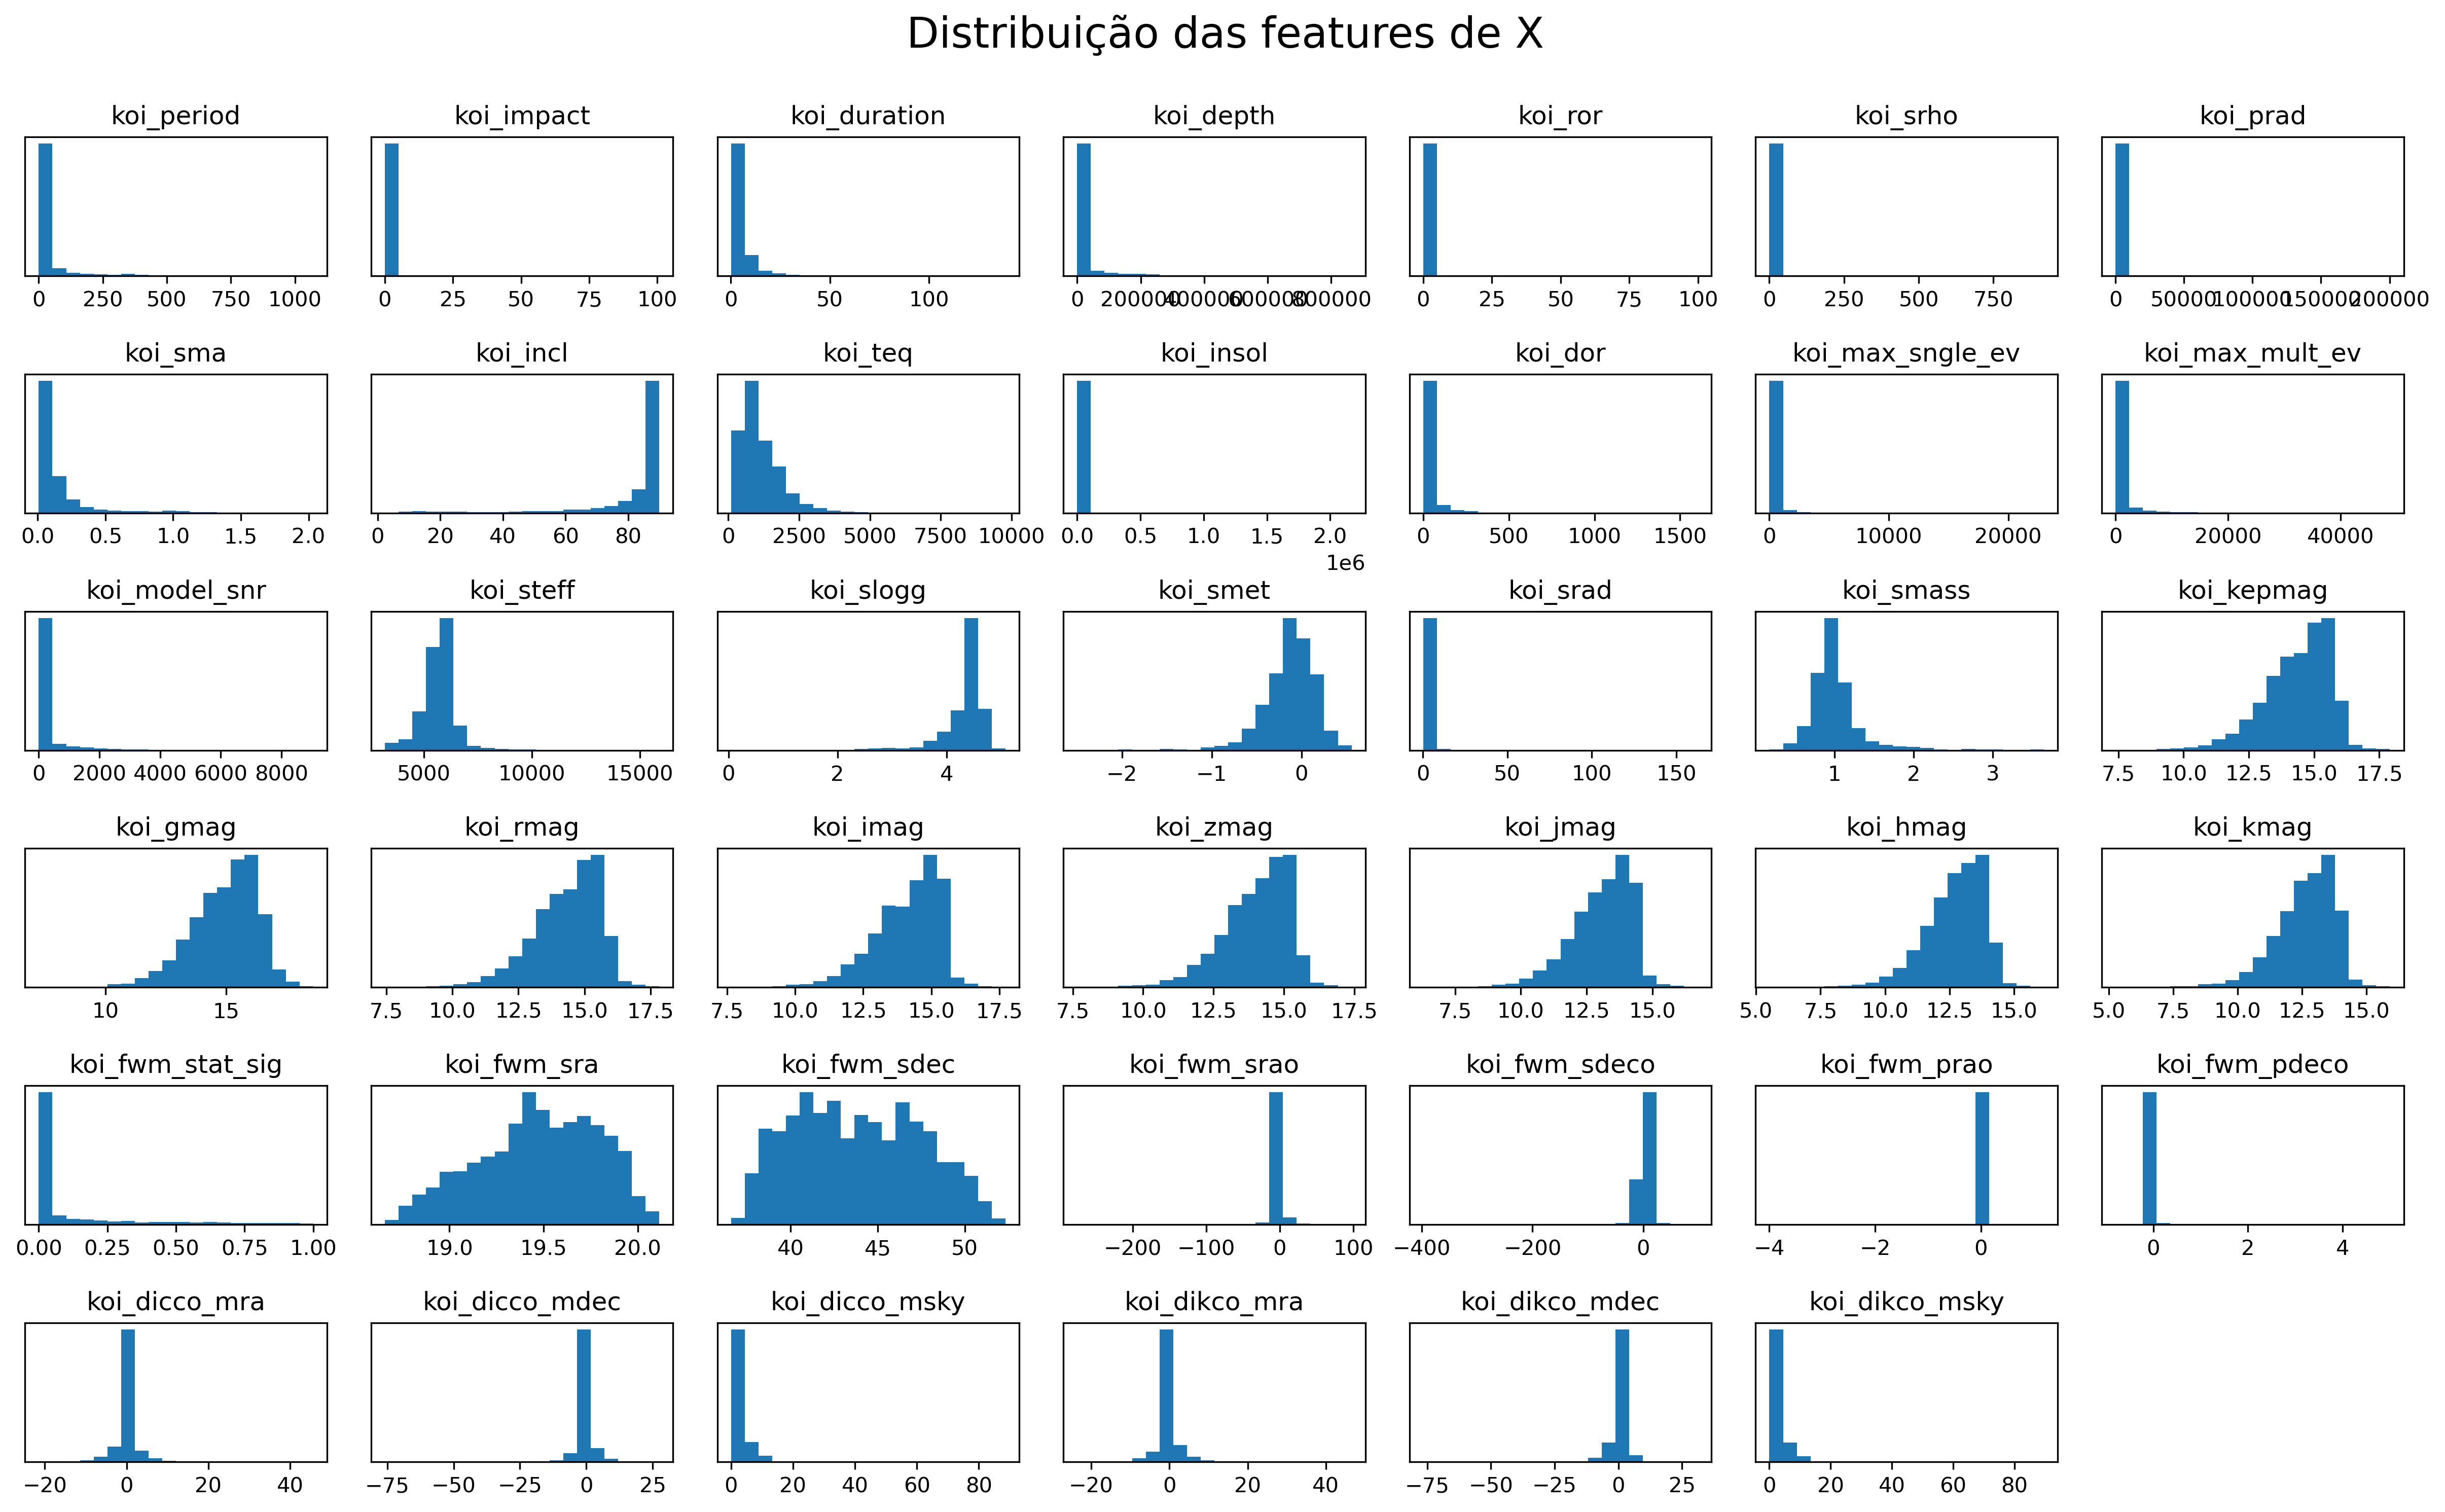

In [8]:
# Estudando a distribuição das features para escolher o algoritmo
plt.rcParams["figure.figsize"] = [16,10]
features = X.shape[1]
linhas = 6
colunas = 7



fig, axs = plt.subplots(linhas, colunas)
fig.suptitle('Distribuição das features de X', fontsize=20)
plt.rc('axes', titlesize=12)    # fontsize of the axes title
plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
plt.rc('ytick', labelsize=4)    # fontsize of the tick labels
plt.rc('font', size=4)          # controls default text sizes

for i in range(linhas):
    for j in range(colunas):
        if i*colunas + j < features:
            axs[i, j].hist(X[:, i*colunas + j], bins=20)
            axs[i, j].set_title(df.columns[i*colunas + j + 1])
            axs[i, j].set_yticks([])
            
        else:
            axs[i, j].axis('off')

fig.tight_layout()
plt.subplots_adjust(top=0.9)

Como as distribuições parecem seguir curvas normais, será usado [`GaussianNB()`](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes).

In [9]:
from sklearn.naive_bayes import GaussianNB


nb_estimator = GaussianNB()
nb_params = {}

nb_grid_estimator, nb_mean_scores = search_for_best_estimator(nb_estimator, nb_params, X_train, y_train)
show_estimator_results(nb_grid_estimator, nb_params, "Naive Bayes")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Resultados para Naive Bayes:
  - Acurária: 0.9137241435035552
  - Parâmetro(s): 


### Decision Tree

Árvores de decisão são compostas por nós que selecionam um atributo e dividem o espaço naquela dimensão. A escolha do atributo segue algum critério que aumente a separação de elementos (eg, entropia, gini). Um dos principais hiperparâmetros é a **profundidade máxima** que a árvore pode atingir.

Em geral, árvores com poucos níveis têm erros de viés maiores, mas árvores com níveis demais podem sobreajustar aos dados de treinamento. Neste experimento, vamos **verificar diferentes valores para a profundidade máxima**:

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Resultados para Decision Tree:
  - Acurária: 0.9456851971557854
  - Parâmetro(s): max_depth: 8


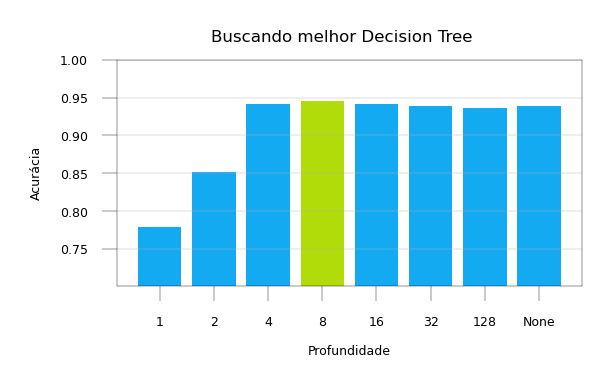

In [10]:
from sklearn.tree import DecisionTreeClassifier, plot_tree


dt_estimator = DecisionTreeClassifier()
dt_params = {"max_depth": [1, 2, 4, 8, 16, 32, 128, None]}

dt_grid_estimator, dt_mean_scores = search_for_best_estimator(dt_estimator, dt_params, X_train, y_train)
plot_estimator_scores(dt_mean_scores, dt_params["max_depth"], "Profundidade", "Buscando melhor Decision Tree")
show_estimator_results(dt_grid_estimator, dt_params, "Decision Tree")

# plot_tree(dt_grid_estimator.best_estimator_)

**Discussão do resultado de _Decision Tree_**: o valor de profundidade máxima que obteve maior acurácia foi 8. Os modelos com menos níveis tinham menos capacidade e sofreram de subajuste.

### SVM

_Support Vector Machines_ são classificadores lineares que buscam um separadores mais seguros dentre os existentes, posicionando-os de forma a maximizar a margem entre o separador e os vetores de suporte. Usando os "truques do _kernel_" é possível aumentar a capacidade do modelo, viabilizando a classificação de dados não-lineares.

Neste experimento **vamos testar diferentes _kernels_** para o SVM usando constante C da margem fluida como parâmetro de regularização. _Kernels_ mais simples podem não atribuir capacidade suficiente para a classificação, provando erro de viés. Por outro lado, _kernels_ muito complexos aumentam demais a capacidade do modelo incorrendo na possibilidade de sobreajuste.

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Resultados para SVM:
  - Acurária: 0.9538553883091698
  - Parâmetro(s): C: 700, kernel: linear


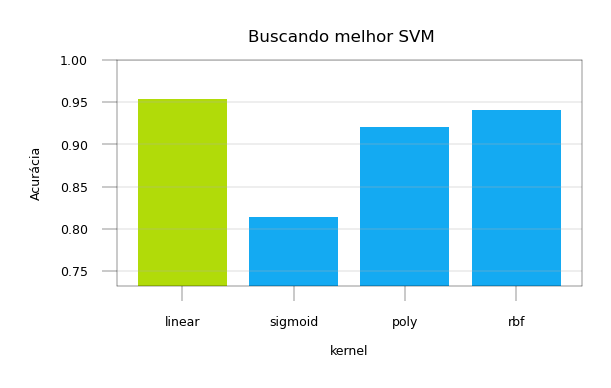

In [11]:
from sklearn.svm import SVC


svm_estimator = SVC()
svm_params = {"kernel": ["linear", "sigmoid", "poly", "rbf"], "C": [700]}

svm_grid_estimator, svm_mean_scores = search_for_best_estimator(svm_estimator, svm_params, X_train, y_train)
plot_estimator_scores(svm_mean_scores, svm_params["kernel"], "kernel", "Buscando melhor SVM")
show_estimator_results(svm_grid_estimator, svm_params, "SVM")

**Discussão do resultado do SVM**: o _kernel_ que obteve melhor acurácia dentre os pesquisados foi o linear, sugerindo que os outros podem ter conferido muita capacidade ao modelo, incorrendo em sobreajuste.

### k-NN

O algoritmo _k-Nearest Neighbors_ classifica dados como um voto de maioria entre dos $k$ dados vizinhos mais próximos do ponto sendo consultado. Quando muitos vizinhos são consultados, o modelo tende a ter menos erro de variância, conseguindo classificar com mais generalização. Se poucos vizinhos são observados, é comum ocorrer sobreajuste especialmente se há muito ruído nos dados.

O **número de vizinhos $k$** a serem analisados é um dos principais hiperparâmetros, e será analisado neste experimento:

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Resultados para k-NN:
  - Acurária: 0.899063279157817
  - Parâmetro(s): n_neighbors: 4


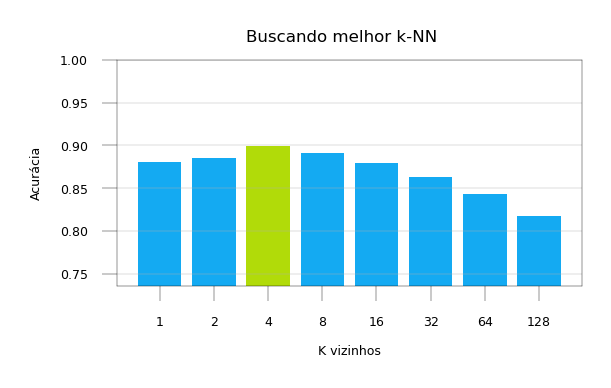

In [12]:
from sklearn.neighbors import KNeighborsClassifier


knn_estimator = KNeighborsClassifier()
knn_params = {"n_neighbors": [1, 2, 4, 8, 16, 32, 64, 128]}

knn_grid_estimator, knn_mean_scores = search_for_best_estimator(knn_estimator, knn_params, X_train, y_train)
plot_estimator_scores(knn_mean_scores, knn_params["n_neighbors"], "K vizinhos", "Buscando melhor k-NN")
show_estimator_results(knn_grid_estimator, knn_params, "k-NN")


**Discussão do resultado do k-NN**: o valor de $k$ que apresentou melhor acurácia foi 4 e valores maiores tiverem acurácia gradativamente menor, indicando que os dados passaram a ser memorizados em um cenário típico de sobreajuste.

### Random Forest

A _Random Forest_ utiliza várias árvores de profundidade limitada e as combina de alguma forma para gerar um estimador com baixo erro de variância. A **quantidade de árvores** é um dos principais hiperparâmetros e valores muito baixos resultam em modelos de baixa capacidade.

Neste experimento, vamos variar a quantidade de árvores em uma _Random Forest_:

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Resultados para Random Forest:
  - Acurária: 0.9685156755009696
  - Parâmetro(s): n_estimators: 1024


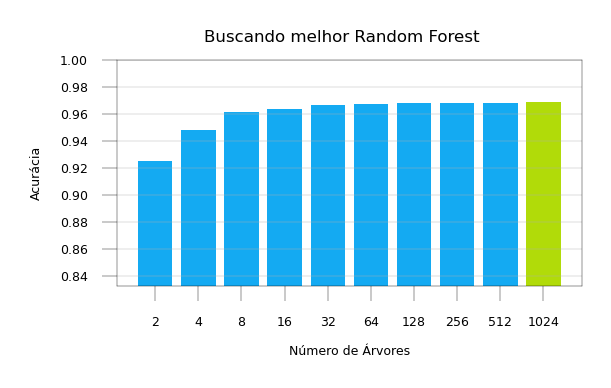

In [13]:
from sklearn.ensemble import RandomForestClassifier


rf_estimator = RandomForestClassifier(random_state=0)
rf_params = {"n_estimators": [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]}

rf_grid_estimator, rf_mean_scores = search_for_best_estimator(rf_estimator, rf_params, X_train, y_train)
plot_estimator_scores(rf_mean_scores, rf_params["n_estimators"], "Número de Árvores", "Buscando melhor Random Forest")
show_estimator_results(rf_grid_estimator, rf_params, "Random Forest")


**Discussão do resultado de _Random Forest_**: a quantidade de árvores com melhor resultado foi 64 e o modelo estabilizou a acurácia com maiores quantidades. Isso indica que, com menos árvores, o modelo não tinha capacidade suficiente para classificar os dados. Por outro lado, mesmo com muitas árvores, não houve erro de sobreajuste significativo.

### Gradient Tree Boosting

_Gradient Tree Boosting_, como técnica _ensemble_, também utiliza de vários estimadores de baixa capacidade para apresentar um estimador robusto. Assim como as _Random Forests_, a técnica também é baseada em árvores de decisão mas consegue usar uma função de perda diferenciável. Árvores são adicionadas ao modelo iterativamente, de forma gulosa em busca da minização da função de perda. Para escolher uma árvore para adicionar o algoritmo a parametriza, modifica os parâmetros e os altera na direção do gradiente.

Um dos principais hiperparâmetros é o **número de iterações**, que equivale à quantidade de árvores de decisão adicionadas (1 adicionada a cada iteração). E neste experimento testaremos diferentes quantidade de iteração:

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Resultados para Gradient Boosting:
  - Acurária: 0.9757263482316002
  - Parâmetro(s): n_estimators: 1024


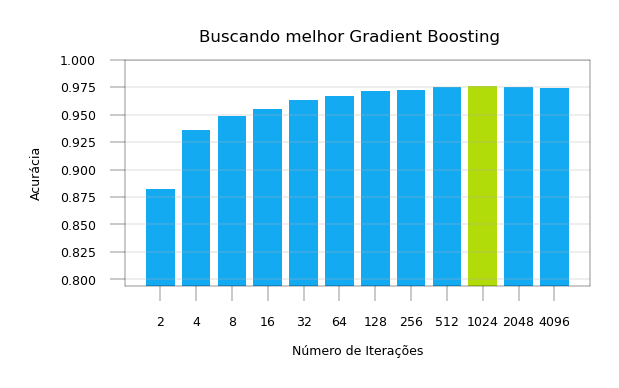

In [14]:
from sklearn.ensemble import GradientBoostingClassifier


gb_estimator = GradientBoostingClassifier(random_state=0)
gb_params = {"n_estimators": [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]}

gb_grid_estimator, gb_mean_scores = search_for_best_estimator(gb_estimator, gb_params, X_train, y_train)
plot_estimator_scores(gb_mean_scores, gb_params["n_estimators"], "Número de Iterações", "Buscando melhor Gradient Boosting")
show_estimator_results(gb_grid_estimator, gb_params, "Gradient Boosting")

**Discussão do resultado de _Gradient Tree Boosting_**: a melhor acurácia obtida foi com 1024 iterações indicando que o modelo consegue atingir capacidades elevadas sem incorrer em erros de variância.

## Comparação dos métodos

Os estimadores com melhores parâmetros foram selecionados para serem comparados entre si. A comparação foi feita de duas formas:

1. Validação cruzada de cada estimador usando _5-fold_ usando dados de treino (80% dos rotulados). Um gráfico com curva ROC e medida de área sob-curva foi gerado.
1. Teste de cada estimador usando os dados de teste (20% dos rotulados). Um gráfico de curva precisão-revocação foi gerado.


In [15]:
from sklearn.metrics import auc, plot_roc_curve, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedKFold

"""
Faz (1) validação cruzada, gerando gráfico de curva AOC-ROC e (2) testando nos dados de teste para gerar curva precision-recall
"""
def analyze_and_plot_estimator(estimator, estimator_name, X_train, y_train, X_test, y_test):
    # 1. curva ROC
    cross_validator = StratifiedKFold(n_splits=5)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4,2))
    fig.suptitle(f"Análise de {estimator_name}", fontsize=6)
    for i, (train, dev) in enumerate(cross_validator.split(X_train, y_train)):
        estimator.fit(X_train[train], y_train[train])
        vizualization = plot_roc_curve(estimator, X_train[dev], y_train[dev], name=f"ROC do fold {i}", alpha=0.3, lw=0.5, ax=ax1)
        interp_tpr = np.interp(mean_fpr, vizualization.fpr, vizualization.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(vizualization.roc_auc)

    ax1.plot([0, 1], [0, 1], linestyle="--", lw=0.5, color="r", label="Acaso", alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    ax1.plot(mean_fpr, mean_tpr, color="b", label=r"ROC média (AUC = %0.4f $\pm$ %0.4f)" % (mean_auc, std_auc), lw=0.5, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=.2,
                    label=r"$\pm$ 1 desvio padrão")
    ax1.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title=f"Curva ROC")
    ax1.set_ylabel("Taxa de verdadeiros positivos")
    ax1.set_xlabel("Taxa de falsos positivos")
    ax1.legend(loc="lower right")
    for axis in ["top", "bottom", "left", "right"]:
        ax1.spines[axis].set_linewidth(0.1)
    ax1.tick_params(width=0.1)
    
    
    # 2. Precisão e revocação em train/test
    visualization = plot_precision_recall_curve(estimator, X_test, y_test, ax=ax2, lw=0.5)
    visualization.ax_.set_title(f"Curva precisão-revocação")

    for axis in ["top", "bottom", "left", "right"]:
        ax2.spines[axis].set_linewidth(0.1)
    ax2.tick_params(width=0.1)
    
    
    fig.tight_layout()
    plt.show()
    return dict(mean_fpr=mean_fpr, mean_tpr=mean_tpr, label=r"ROC média (AUC = %0.4f $\pm$ %0.4f) %s" % (mean_auc, std_auc, estimator_name))


### Gráficos de ROC e Precisão-Revocação de cada método

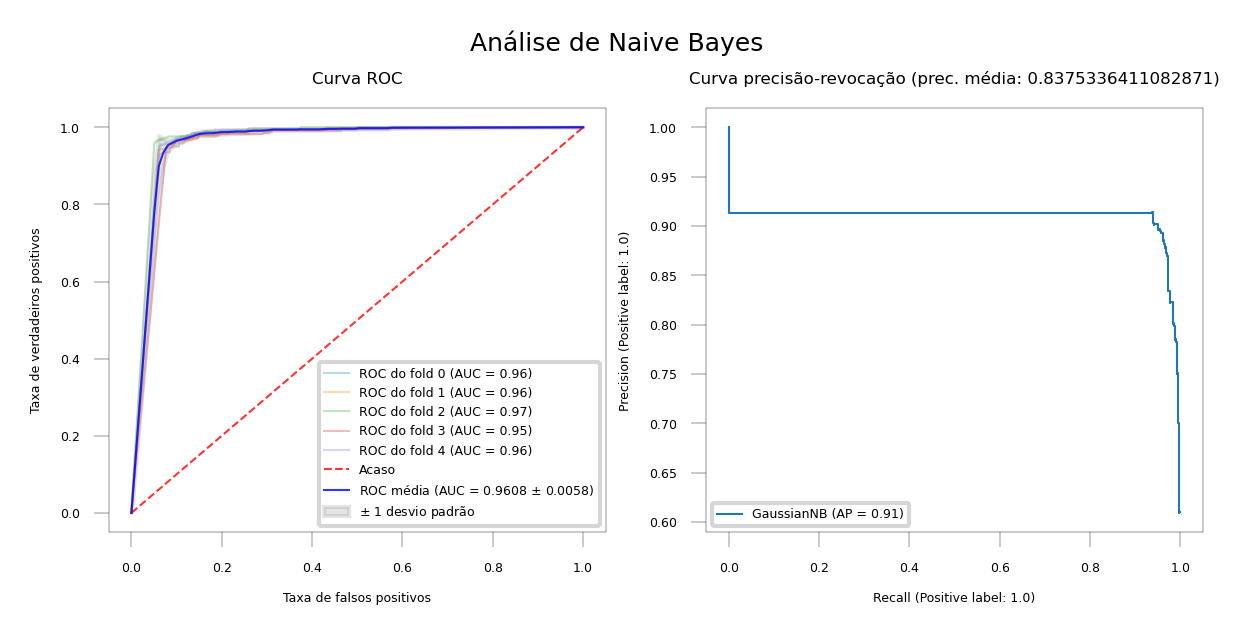

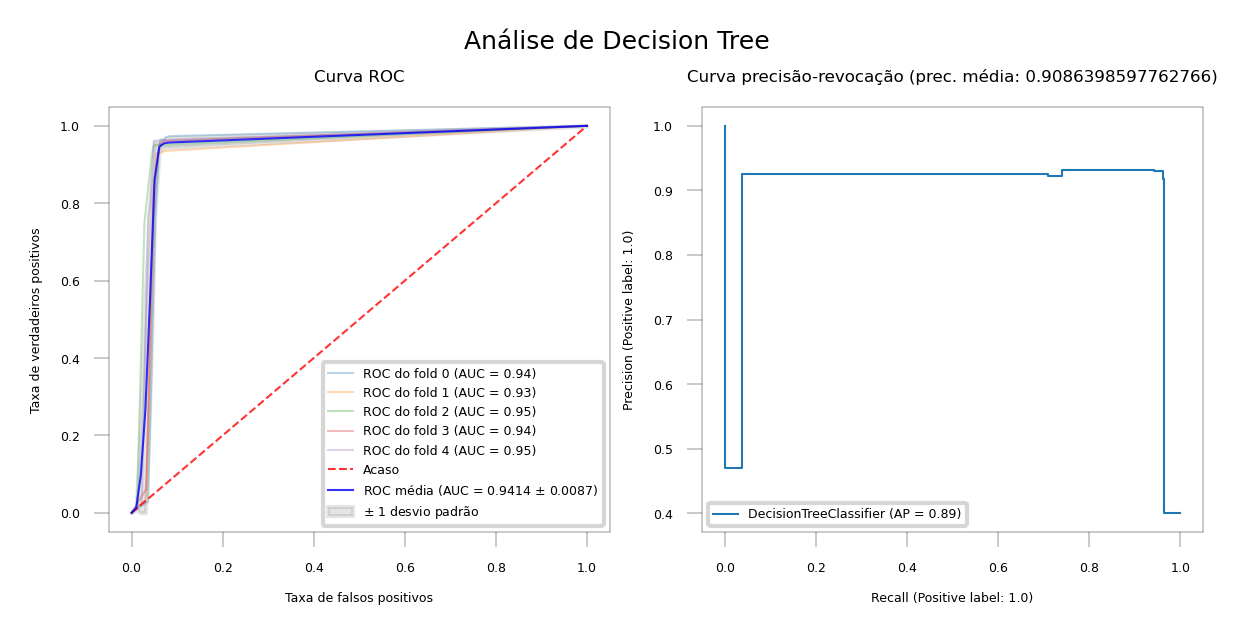

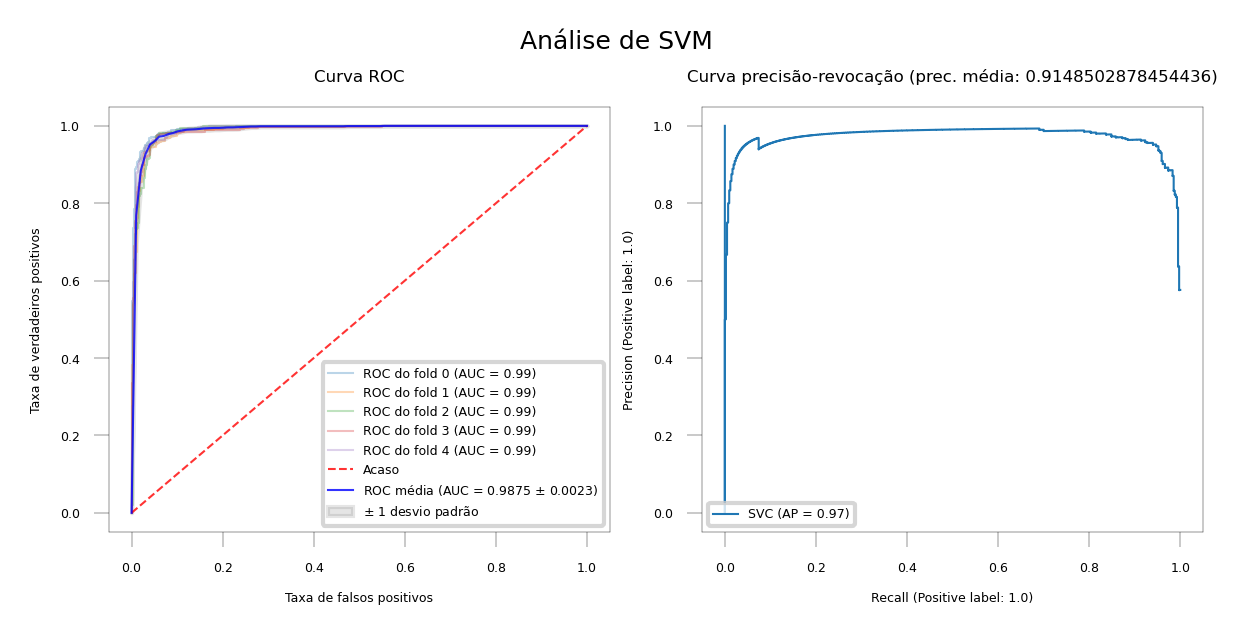

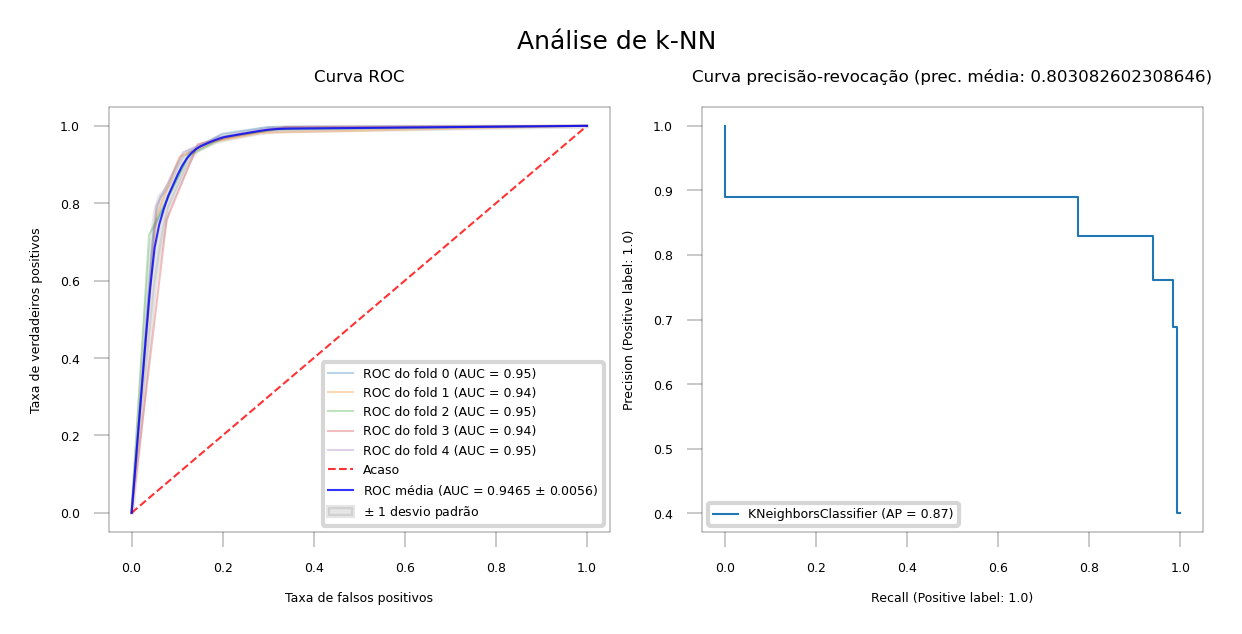

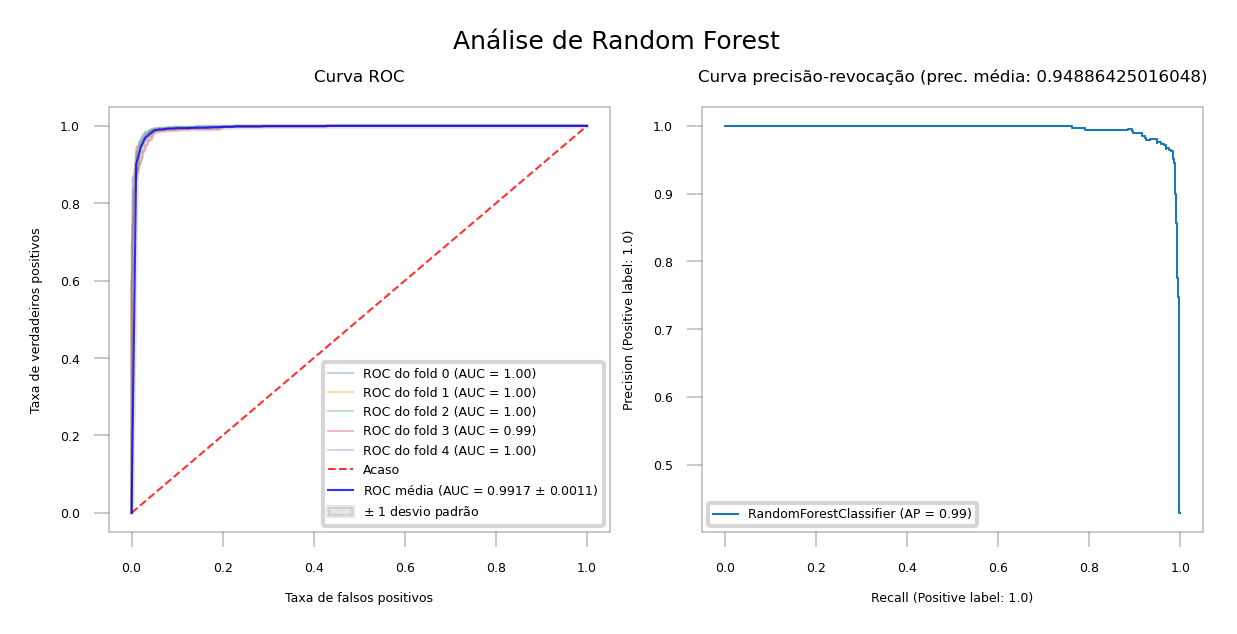

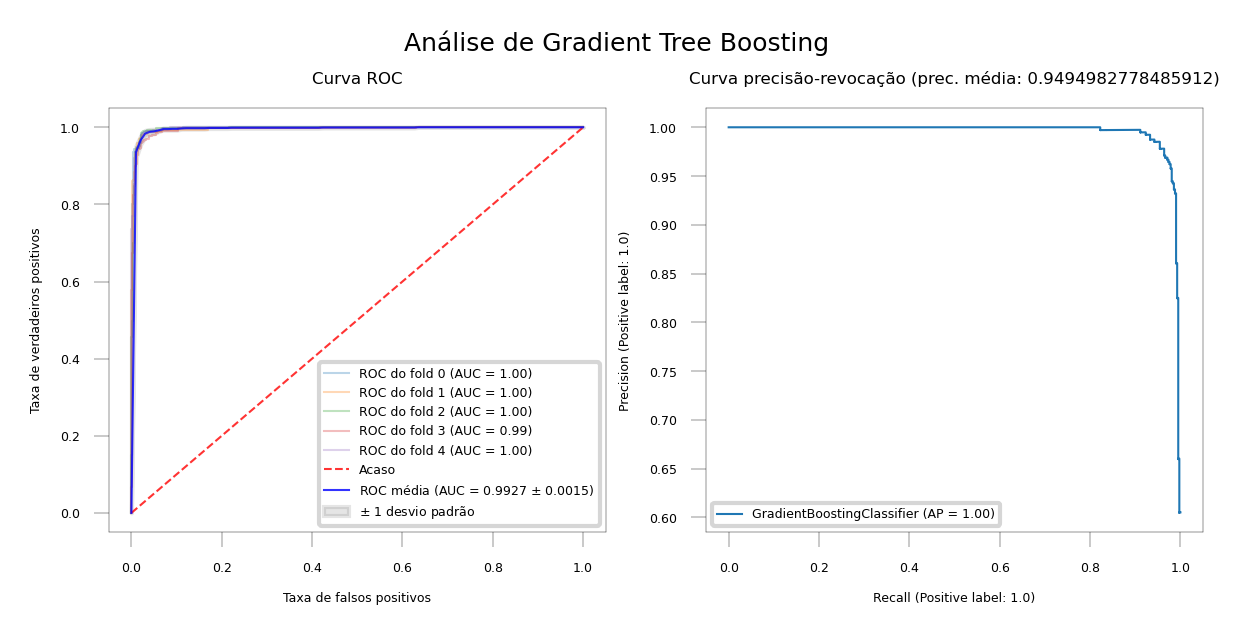

In [16]:
nb_roc = analyze_and_plot_estimator(nb_grid_estimator.best_estimator_, "Naive Bayes", X_train, y_train, X_test, y_test)
dt_roc = analyze_and_plot_estimator(dt_grid_estimator.best_estimator_, "Decision Tree", X_train, y_train, X_test, y_test)
svm_roc = analyze_and_plot_estimator(svm_grid_estimator.best_estimator_, "SVM", X_train, y_train, X_test, y_test)
knn_roc = analyze_and_plot_estimator(knn_grid_estimator.best_estimator_, "k-NN", X_train, y_train, X_test, y_test)
rf_roc = analyze_and_plot_estimator(rf_grid_estimator.best_estimator_, "Random Forest", X_train, y_train, X_test, y_test)
gb_roc = analyze_and_plot_estimator(gb_grid_estimator.best_estimator_, "Gradient Tree Boosting", X_train, y_train, X_test, y_test)

### Análise combinada das curvas



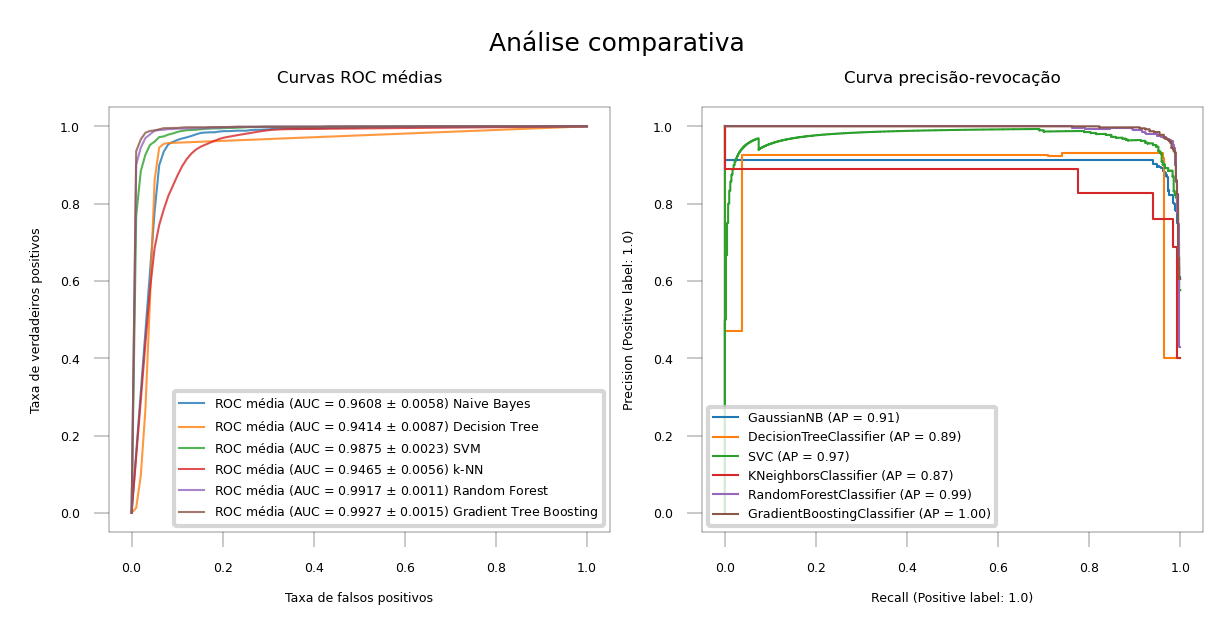

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4,2))
fig.suptitle(f"Análise comparativa", fontsize=6)
for roc in [nb_roc, dt_roc, svm_roc, knn_roc, rf_roc, gb_roc]:
    ax1.plot(roc["mean_fpr"], roc["mean_tpr"], label=roc["label"], lw=0.5, alpha=.8)
ax1.set_title("Curvas ROC médias")
ax1.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_ylabel("Taxa de verdadeiros positivos")
ax1.set_xlabel("Taxa de falsos positivos")
for axis in ["top", "bottom", "left", "right"]:
    ax1.spines[axis].set_linewidth(0.1)
ax1.tick_params(width=0.1)


for estimator in [
    nb_grid_estimator.best_estimator_,
    dt_grid_estimator.best_estimator_,
    svm_grid_estimator.best_estimator_,
    knn_grid_estimator.best_estimator_,
    rf_grid_estimator.best_estimator_,
    gb_grid_estimator.best_estimator_]:
    visualization = plot_precision_recall_curve(estimator, X_test, y_test, ax=ax2, lw=0.5)

visualization.ax_.set_title(f"Curva precisão-revocação")

for axis in ["top", "bottom", "left", "right"]:
    ax2.spines[axis].set_linewidth(0.1)
ax2.tick_params(width=0.1)

fig.tight_layout()    
plt.show()

A (1) comparação por meio da curva ROC nos dados de treinamento/desenvolvimento (80% dos rotulados) possibilita (1.a) a análise da taxa de acerto de cada estimador (verdadeiros positivos) em relação à taxa de falsos positivos, mas também (1.b) ter uma boa ideia do comportamento de cada estimador considerando-se a variância dos dados (ao analisar cada _fold_).

Em relação à (a) área sob a curva, pode-se perceber que SVM, _Random Forest_ e _Gradient Boosting_ obtiveram resultados semelhantes ($0.99$) e o menor valor foi obtido por _Decision Tree_ ($0.94 \pm 0.01$). Em relação à análise da (b) robustez à variância possibilitada pela validação cruzada (mas ainda usando apenas dados de treino/desenvolvimento sendo 80% dos rotulados), o desvio padrão dos três melhores estimadores ficou próximo de $0$.

O teste seguinte foi (2) apresentar os dados de teste (20% dos rotulados) a cada estimador para fazer uma análise de precisão e revocação. Para isso foram geradas curvas de precisão-revocação dos estimadores e analisada a média da precisão obtida por cada um. Nessa situação, os melhores valores de precisão foram das técnicas _ensemble_ de _Random Forest_ e _Gradient Tree Boosting_, ambas apresentando $0.99$. Diferente da análise usando apenas 80% dos dados rotulados, o SVM obteve uma pontuação de precisão média menor ($0.97$).

Nesse caso, dentre os modelos obtidos por _Random Forest_ e _Gradient Tree Boosting_, o tempo necessário para treinamento e predição de _Random Forest_ foi menor e, por isso, seria o modelo escolhido para o problema de detecção de exoplanetas com os dados da sonda Kepler da Nasa.